# Sentiment Analysis on Free Fire Reviews


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install sastrawi

In [ ]:
import numpy as np
import pandas as pd
import os

import nltk
import re
import string as s
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
csv_file_path = '/content/drive/MyDrive/sentimenAnalysisFreeFire/dataset_sentimentAnalysis_ff - Fix.csv'  # Update this to your CSV file path
df = pd.read_csv(csv_file_path)

# Assuming the first column is the target (y) and the second column is the feature (x)
y = df.iloc[:, 0].astype(int)  # Convert to integer
X = df.iloc[:, 1].astype(str)  # Convert to string
# Split the dataset into training and testing sets with a 90/10 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Convert Series to DataFrame for easier CSV export if necessary
train_df = pd.DataFrame({'train_y': y_train, 'train_x': X_train})
test_df = pd.DataFrame({'test_y': y_test, 'test_x': X_test})

# Export to CSV
train_df.to_csv('/content/drive/MyDrive/sentimenAnalysisFreeFire/train_dataset.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/sentimenAnalysisFreeFire/test_dataset.csv', index=False)

print('Datasets have been split and saved.')


Datasets have been split and saved.


## Data input and Checking

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/sentimenAnalysisFreeFire/train_dataset.csv',
                         header=0, names=['label', 'comments'])
test_data = pd.read_csv('/content/drive/MyDrive/sentimenAnalysisFreeFire/test_dataset.csv',
                        header=0, names=['label', 'comments'])

train_data['label'] = pd.to_numeric(train_data['label'], errors='coerce')
test_data['label'] = pd.to_numeric(test_data['label'], errors='coerce')
train_data['label'].fillna(0, inplace=True)
test_data['label'].fillna(0, inplace=True)


train_data.head()

,label,comments
0,1,"semenjak update terakhir, saya selalu terkenda..."
1,1,Game nya bagus tetapi setiap saya main di rank...
2,1,"Gamenya bagus tapi, ada beberapa hal yg menuru..."
3,1,Ya free fire itu lumayan bagus tetapi ada bug ...
4,1,Gamenya seru sih memang seru tapi kok banyak b...


In [ ]:
test_data.head()

,label,comments
0,1,"Gamenya udah bagus, cuman masih sering ada bug..."
1,1,1 orang merasa ulasan ini berguna
2,0,"seru apaaan, iya seru sih seru tp itu gangguan..."
3,1,Updatenya sudah lumayan cuman tolong kedepan n...
4,1,Saat keren


In [ ]:
print(train_data.shape)

(800, 2)


In [ ]:
print(test_data.shape)

(200, 2)


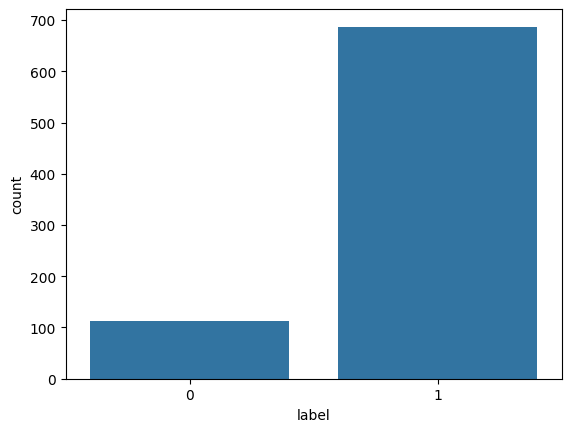

In [ ]:
sns.countplot(x = 'label', data = train_data)
plt.show()

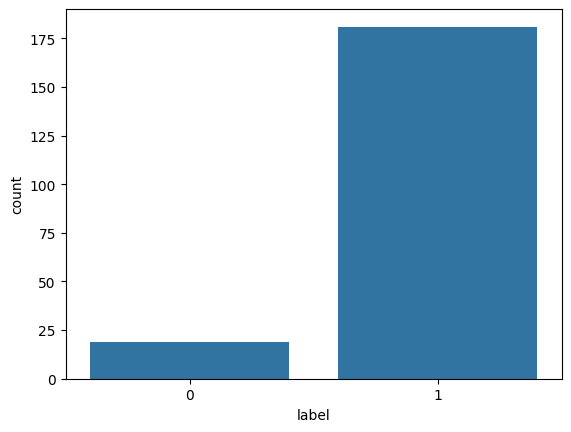

In [ ]:
sns.countplot(x = 'label', data = test_data)
plt.show()

In [ ]:
train_x = train_data.comments
test_x = test_data.comments
train_y = train_data.label
test_y = test_data.label

## Preprocessing

### Removing Tags

In [ ]:
train_x = train_x.fillna('')
test_x = test_x.fillna('')

In [ ]:
train_x = train_x.astype(str)
test_x = test_x.astype(str)

In [ ]:
import re
import pandas as pd

# Example modification of the remove_html_tag function
def remove_html_tag(text):
    text = str(text)  # Convert every input to string
    html = re.compile('<.*?>')  # Adjusted regex to ensure it works correctly
    cleaned_text = html.sub('', text)
    return cleaned_text


example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(remove_html_tag)
test_x = test_x.apply(remove_html_tag)

example_text = train_x[2]
print("\nAfter Preprocessing:")
print(example_text)

Before Preprocessing:
Gamenya bagus tapi, ada beberapa hal yg menurut saya nyebelin, 1. suara step, kita cuman denger dan GK tau itu dimana, garena kan bisa miripin yg di PUBG, bisa di lihat dari mana step lawan. 2.ini masalah nya pas lagi war, kalo pake medkit, efek pemulihannya kelamaan, saat selesai medkit, langsung di serang dari belakang, atau pas selesai pake super medkit dan musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main antara solo maupun squad, gue mah dua

After Preprocessing:
Gamenya bagus tapi, ada beberapa hal yg menurut saya nyebelin, 1. suara step, kita cuman denger dan GK tau itu dimana, garena kan bisa miripin yg di PUBG, bisa di lihat dari mana step lawan. 2.ini masalah nya pas lagi war, kalo pake medkit, efek pemulihannya kelamaan, saat selesai medkit, langsung di serang dari belakang, atau pas selesai pake super medkit dan musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah m

### Removing Links

In [ ]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
Gamenya bagus tapi, ada beberapa hal yg menurut saya nyebelin, 1. suara step, kita cuman denger dan GK tau itu dimana, garena kan bisa miripin yg di PUBG, bisa di lihat dari mana step lawan. 2.ini masalah nya pas lagi war, kalo pake medkit, efek pemulihannya kelamaan, saat selesai medkit, langsung di serang dari belakang, atau pas selesai pake super medkit dan musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main antara solo maupun squad, gue mah dua
After Preprocessing:
Gamenya bagus tapi, ada beberapa hal yg menurut saya nyebelin, 1. suara step, kita cuman denger dan GK tau itu dimana, garena kan bisa miripin yg di PUBG, bisa di lihat dari mana step lawan. 2.ini masalah nya pas lagi war, kalo pake medkit, efek pemulihannya kelamaan, saat selesai medkit, langsung di serang dari belakang, atau pas selesai pake super medkit dan musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah ma

### Removing stopwords
Stopwords yang digunakan berdasarkan dari pustaka nltk.corpus yang mencakup kata kata sebagai berikut:


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Initialize the StopWordRemover only once to improve efficiency
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

def remove_stopwords(text):
    # Convert every input to string, handling NaN and similar cases
    text = str(text)

    cleaned_text = stopword_remover.remove(text)

    return cleaned_text


example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
Gamenya bagus tapi, ada beberapa hal yg menurut saya nyebelin, 1. suara step, kita cuman denger dan GK tau itu dimana, garena kan bisa miripin yg di PUBG, bisa di lihat dari mana step lawan. 2.ini masalah nya pas lagi war, kalo pake medkit, efek pemulihannya kelamaan, saat selesai medkit, langsung di serang dari belakang, atau pas selesai pake super medkit dan musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main antara solo maupun squad, gue mah dua
After Preprocessing:
Gamenya bagus tapi, beberapa yg saya nyebelin, 1. suara step, cuman denger GK tau dimana, garena kan miripin yg PUBG, lihat mana step lawan. 2.ini masalah nya pas war, kalo pake medkit, efek pemulihannya kelamaan, selesai medkit, langsung di serang belakang, pas selesai pake super medkit musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main solo maupun squad, gue mah


In [ ]:
def garena_remove(text):
    garena = re.compile(r'\b\w*?garena\w*?\b')
    return garena.sub(r'', text)

example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(garena_remove)
test_x = test_x.apply(garena_remove)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
Gamenya bagus tapi, beberapa yg saya nyebelin, 1. suara step, cuman denger GK tau dimana, garena kan miripin yg PUBG, lihat mana step lawan. 2.ini masalah nya pas war, kalo pake medkit, efek pemulihannya kelamaan, selesai medkit, langsung di serang belakang, pas selesai pake super medkit musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main solo maupun squad, gue mah
After Preprocessing:
Gamenya bagus tapi, beberapa yg saya nyebelin, 1. suara step, cuman denger GK tau dimana,  kan miripin yg PUBG, lihat mana step lawan. 2.ini masalah nya pas war, kalo pake medkit, efek pemulihannya kelamaan, selesai medkit, langsung di serang belakang, pas selesai pake super medkit musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main solo maupun squad, gue mah


### Tokenization

In [ ]:
def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token

example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)
#train_x = train_x.apply(word_tokenize)
#test_x = test_x.apply(word_tokenize)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
Gamenya bagus tapi, beberapa yg saya nyebelin, 1. suara step, cuman denger GK tau dimana,  kan miripin yg PUBG, lihat mana step lawan. 2.ini masalah nya pas war, kalo pake medkit, efek pemulihannya kelamaan, selesai medkit, langsung di serang belakang, pas selesai pake super medkit musuh udah langsung nyamperin glowal, malah gue yg mokad duluan. 3.untuk gameplay, kyk susah main solo maupun squad, gue mah
After Preprocessing:
['Gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '1', 'suara', 'step', 'cuman', 'denger', 'GK', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'PUBG', 'lihat', 'mana', 'step', 'lawan', '2', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 'pas', 'selesai', 'pake', 'super', 'medkit', 'musuh', 'udah', 'langsung', 'nyamperin', 'glowal', 'malah', 'gue', 'yg', 'mokad', 'duluan', '3', 'untuk', 'gameplay', 'kyk', 'susah', 'main

### Lowercasing

In [ ]:
example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
['Gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '1', 'suara', 'step', 'cuman', 'denger', 'GK', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'PUBG', 'lihat', 'mana', 'step', 'lawan', '2', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 'pas', 'selesai', 'pake', 'super', 'medkit', 'musuh', 'udah', 'langsung', 'nyamperin', 'glowal', 'malah', 'gue', 'yg', 'mokad', 'duluan', '3', 'untuk', 'gameplay', 'kyk', 'susah', 'main', 'solo', 'maupun', 'squad', 'gue', 'mah']
After Preprocessing:
['gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '1', 'suara', 'step', 'cuman', 'denger', 'gk', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'pubg', 'lihat', 'mana', 'step', 'lawan', '2', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 

### Removing Numbers

In [ ]:
def remove_number(list):
    return [''.join(char for char in word if char not in s.digits) for word in list if word]

example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
['gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '1', 'suara', 'step', 'cuman', 'denger', 'gk', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'pubg', 'lihat', 'mana', 'step', 'lawan', '2', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 'pas', 'selesai', 'pake', 'super', 'medkit', 'musuh', 'udah', 'langsung', 'nyamperin', 'glowal', 'malah', 'gue', 'yg', 'mokad', 'duluan', '3', 'untuk', 'gameplay', 'kyk', 'susah', 'main', 'solo', 'maupun', 'squad', 'gue', 'mah']
After Preprocessing:
['gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '', 'suara', 'step', 'cuman', 'denger', 'gk', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'pubg', 'lihat', 'mana', 'step', 'lawan', '', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 'p

In [ ]:
#Menggabungkan kembali kata menjadi kalimat
def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

example_text = train_x[2]
print("Before Preprocessing:")
print(example_text)

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)

example_text = train_x[2]
print("After Preprocessing:")
print(example_text)

Before Preprocessing:
['gamenya', 'bagus', 'tapi', 'beberapa', 'yg', 'saya', 'nyebelin', '', 'suara', 'step', 'cuman', 'denger', 'gk', 'tau', 'dimana', 'kan', 'miripin', 'yg', 'pubg', 'lihat', 'mana', 'step', 'lawan', '', 'ini', 'masalah', 'nya', 'pas', 'war', 'kalo', 'pake', 'medkit', 'efek', 'pemulihannya', 'kelamaan', 'selesai', 'medkit', 'langsung', 'di', 'serang', 'belakang', 'pas', 'selesai', 'pake', 'super', 'medkit', 'musuh', 'udah', 'langsung', 'nyamperin', 'glowal', 'malah', 'gue', 'yg', 'mokad', 'duluan', '', 'untuk', 'gameplay', 'kyk', 'susah', 'main', 'solo', 'maupun', 'squad', 'gue', 'mah']
After Preprocessing:
gamenya bagus tapi beberapa yg saya nyebelin  suara step cuman denger gk tau dimana kan miripin yg pubg lihat mana step lawan  ini masalah nya pas war kalo pake medkit efek pemulihannya kelamaan selesai medkit langsung di serang belakang pas selesai pake super medkit musuh udah langsung nyamperin glowal malah gue yg mokad duluan  untuk gameplay kyk susah main solo 

In [ ]:
vocab_size = 1500
embedding_dim = 50
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# Pad sequences to make them of the same length
train_padded_sequences = pad_sequences(train_sequences,  maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels_fix = np.array(train_y)
test_labels_fix = np.array(test_y)

# Ensure the shape of padded_sequences and labels_fix
print("Shape of padded_sequences:", train_padded_sequences.shape)
print("Shape of labels_fix:", train_labels_fix.shape)

# Verify the first few padded sequences and labels
print("First few padded sequences:", train_padded_sequences[:5])
print("First few labels:", train_labels_fix[:5])

Shape of padded_sequences: (800, 50)
Shape of labels_fix: (800,)
First few padded sequences: [[ 316   33  690   62    1  606   18  606  442  976    1  384   24   36
  1219  483   18   36    1  977   27  443  977  799 1220    3  541  443
   691  692   26    7  691   67  607   77   39  316   33  117    1  194
     4  279  295    7   34  178 1221  120]
 [   3    2    5  226    6   52  172  179   13  317 1222  296  542   60
   543  800   49   78   39   39   33    7  254 1223    5   22    8    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  53    5   55  129   17    7 1224  385 1225  167 1226   48  214    1
    83    1   17  608  354  355 1225  263   34   84    2   24  215   20
    94  609  801    1 1227  356  609  114   16 1228  610   24  356   94
  1229  609   15   11  114    1  157   43]
 [  87   38   50  178    5   32    4   29  693    4   56   21   21  105
    13  158    5  235  544  545  690  296   95   32   85  

## Model Creation
Kami menggunakan model berbasis lstm dengan framework tensorflow

In [ ]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001))),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])



    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

## Training
Bagian dibawah akan menjelaskan proses training

In [ ]:
model = create_model(vocab_size, embedding_dim, max_length)

history = model.fit(train_padded_sequences, train_labels_fix, epochs=15, validation_data=(test_padded_sequences, test_labels_fix))

Epoch 1/15
25/25 [==============================] - 7s 73ms/step - loss: 0.6995 - accuracy: 0.8413 - val_loss: 0.5759 - val_accuracy: 0.9050
Epoch 2/15
25/25 [==============================] - 1s 30ms/step - loss: 0.5338 - accuracy: 0.8587 - val_loss: 0.3848 - val_accuracy: 0.9050
Epoch 3/15
25/25 [==============================] - 1s 31ms/step - loss: 0.4722 - accuracy: 0.8587 - val_loss: 0.3674 - val_accuracy: 0.9050
Epoch 4/15
25/25 [==============================] - 1s 32ms/step - loss: 0.4530 - accuracy: 0.8587 - val_loss: 0.3595 - val_accuracy: 0.9050
Epoch 5/15
25/25 [==============================] - 1s 32ms/step - loss: 0.4115 - accuracy: 0.8587 - val_loss: 0.3385 - val_accuracy: 0.9050
Epoch 6/15
25/25 [==============================] - 1s 30ms/step - loss: 0.3713 - accuracy: 0.8587 - val_loss: 0.3130 - val_accuracy: 0.9050
Epoch 7/15
25/25 [==============================] - 1s 32ms/step - loss: 0.3098 - accuracy: 0.8662 - val_loss: 0.2954 - val_accuracy: 0.9050
Epoch 8/15
25

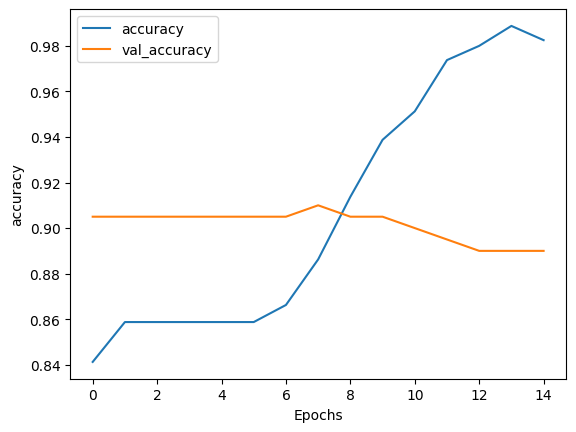

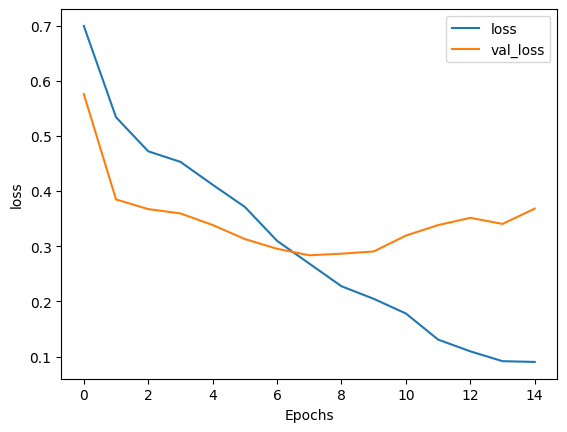

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaluation

### Metriks Evaluasi
Metriks evaluasi yang saya gunakan adalah F1 Score, akurasi, dan confusion matrix plot

7/7 [==============================] - 1s 15ms/step


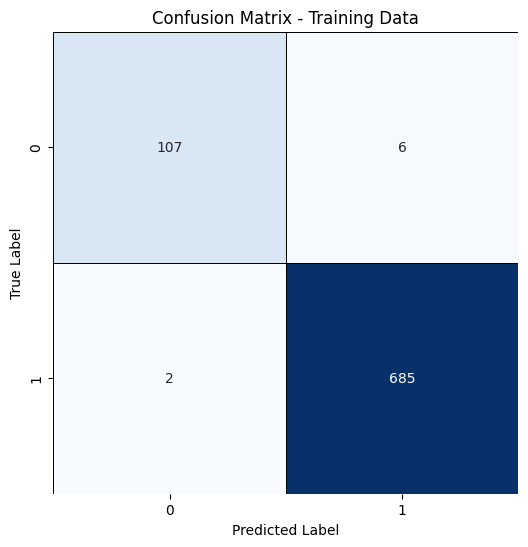

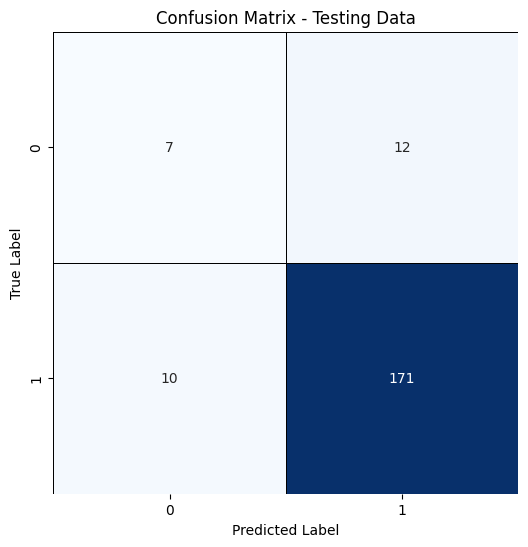

Training Data:
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1

Testing Data:
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 0
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1
Predicted Label: [1.] | Actual Label: 1


In [ ]:
# Make predictions
train_predictions = model.predict(train_padded_sequences)
test_predictions = model.predict(test_padded_sequences)

# Convert predictions to label indices
train_pred_labels = np.round(train_predictions)
test_pred_labels = np.round(test_predictions)

# Compute confusion matrices
conf_matrix_train = confusion_matrix(train_labels_fix, train_pred_labels)
conf_matrix_test = confusion_matrix(test_labels_fix, test_pred_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_train, title='Confusion Matrix - Training Data')
plot_confusion_matrix(conf_matrix_test, title='Confusion Matrix - Testing Data')

print("Training Data:")
for i in range(10):
    print("Predicted Label:", train_pred_labels[i], "| Actual Label:", train_labels_fix[i])

# Print the first 10 predicted labels and actual labels for the testing data
print("\nTesting Data:")
for i in range(10):
    print("Predicted Label:", test_pred_labels[i], "| Actual Label:", test_labels_fix[i])

# Kesimpulan
Dalam percobaan ini telah dilakukan proses Klasifikasi Komentar Aplikasi Free Fire menggunakan metode Bidirectional LSTM (Long Short-Term Memory). Hasil yang kami dapatkan adalah tingkat accuracy 98% dan validation 89%.

Bidirectional LSTM, dengan kemampuannya untuk menangkap informasi secara dua arah (Forward dan Backward) mampu menghasilkan hasil training yang dapat mengklasifikasi dan memprediksi komentar positif ataupun negatif